In [1]:
import numpy as np
import pandas
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import pickle
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler 

## Constants

In [2]:
# file_path = "/nfs/lab/varpred/Final_Results/final_matrices/"
file_path = "./"
# t1d_mat = file_path + "T1D_new_04_09_short.bed"
t1d_mat = file_path + "t1d_final_short_after_loci_filtering.bed"
# t2d_mat = file_path + "T2D_new_04_09_short.bed"
t2d_mat = file_path + "t2d_final_short_after_loci_filtering.bed"
# topmed_mat = file_path + "topmed_final.bed"

# Automating Experiments

## Data Ingestion

In [3]:
# Raw data from csv
t1d_data_raw = pandas.read_csv(t1d_mat, sep='\s+')
print("original num rows", len(t1d_data_raw))
t1d_data_raw = t1d_data_raw.sort_values(by=['Probability'])
t1d_data_dedup = t1d_data_raw.drop_duplicates(subset=['VarID'], keep='first')
# t1d_data_dup = t1d_data_raw.drop(['Locus', 'VarID', 'Probability'], axis=1).duplicated(keep='first')


# Splitting labels and data
# t1d_labels_raw = t1d_data_raw["Probability"][t1d_data_dup]
# t1d_data_raw = t1d_data_raw.drop(['Locus', 'VarID', 'Probability'], axis=1)[t1d_data_dup]
print("Resulting num rows", len(t1d_data_dedup))

t1d_labels_raw = t1d_data_dedup["Probability"]
t1d_data_raw = t1d_data_dedup.drop(['Locus', 'VarID', 'Probability'], axis=1)

# Resetting index for splitting
t1d_data = t1d_data_raw.reset_index(drop=True)
t1d_labels = t1d_labels_raw.reset_index(drop=True)

original num rows 12380
Resulting num rows 11758


In [4]:
# Removing imbalance columns
t1d_data = t1d_data.drop(columns=[col for col in t1d_data.columns if 'imbal' in col])

## Label Spreading Model Tests

In [7]:
# Categorical labelling
def label_prob(prob, prob_threshold_high, prob_threshold_low):
    if prob > prob_threshold_high:
        return 1
    elif prob < prob_threshold_low:
        return 0
    else:
        return -1
    
# Split unknown and known data
def sort_data(data, labels):
    known_data_bool = labels != -1
    all_data = data.copy(deep=True)
    all_data.insert(len(all_data.columns), 'label', labels)
    all_data.insert(len(all_data.columns), 'known', known_data_bool)
    all_known_data = all_data[all_data.known == True]
    all_unknown_data = all_data[all_data.known == False]
    known_data = all_known_data.drop(['label', 'known'], axis=1)
    known_labels = all_known_data['label']
    unknown_data = all_unknown_data.drop(['label', 'known'], axis=1)
    unknown_labels = all_unknown_data['label']
    
    return all_known_data, unknown_data, known_data, known_labels, unknown_data, unknown_labels


def create_splitter(all_known_data, unknown_data):
    ss = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
    splits = ss.split(all_known_data)

    def custom_splitter(splits):
        for train_index, test_index in splits:
            train_index = np.append(train_index, list(unknown_data.index.values))
            yield train_index, test_index
            
    return splits, custom_splitter


def perform_cv(model, data, labels):
    all_known_data, unknown_data, known_data, known_labels, unknown_data, unknown_labels = sort_data(data, labels)
    splits, custom_splitter = create_splitter(all_known_data, unknown_data)
    cv_score = cross_val_score(model, data, y=labels, cv=custom_splitter(splits), verbose=1, n_jobs=1)
    return np.mean(cv_score)

def cv(model, data, labels):
    all_known_data, unknown_data, known_data, known_labels, unknown_data, unknown_labels = sort_data(data, labels)
    ss = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
    splits = ss.split(known_data, known_labels)
    
    total_acc_score = 0
    total_prec_score = 0
    total_rec_score = 0
    total_fp_score = 0
    total_tp_score = 0
    total_tn_score = 0
    total_fn_score = 0
    num = 0
    for train_idx, test_idx in splits:
        train_data = known_data.iloc[train_idx].append(unknown_data)
        test_data = known_data.iloc[test_idx]
        train_labels = known_labels.iloc[train_idx].append(unknown_labels)
        test_labels = known_labels.iloc[test_idx]
        
        rus = RandomUnderSampler(random_state=42)
#         print("Test labels 0/1:", len(test_labels[test_labels == 0]), len(test_labels[test_labels == 1]))
        test_data, test_labels = rus.fit_resample(test_data, test_labels)
#         print("After balance:", len(test_labels[test_labels == 0]), len(test_labels[test_labels == 1]))

        model.fit(train_data, train_labels)
        
        # Predict on test
        pred_labels = model.predict(test_data)

        # Measure accuracy
        acc = accuracy_score(test_labels, pred_labels)
        prec = precision_score(test_labels, pred_labels)
        rec = recall_score(test_labels, pred_labels)
        total_acc_score += acc
        total_prec_score += prec
        total_rec_score += rec
        tn, fp, fn, tp = confusion_matrix(test_labels, pred_labels).ravel()
        total_fp_score += (fp / (fp + tp))
        total_tp_score += (tp / (fp + tp))
        total_fn_score += (fn / (fn + tn))
        total_tn_score += (tn / (fn + tn))
        num += 1

    print("Avg accuracy, precision, recall:", total_acc_score / num, total_prec_score / num, total_rec_score / num)
    print("fp, tp, tn, fn:", total_fp_score / num, total_tp_score / num, total_tn_score / num, total_fn_score / num)
    return total_acc_score / num, total_prec_score / num, total_rec_score / num, total_fp_score / num, total_tp_score / num, total_fn_score / num, total_tn_score / num

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

high_prob_thresholds = [0.01, 0.001, 0.0001]
low_prob_thresholds = [0.000005, 0.000006, 0.000007, 0.000008, 0.00001]
# high_prob_thresholds = [0.001]
# low_prob_thresholds = [0.000005]
# low_prob_thresholds = [0.00002, 0.000025, 0.00003]
# kernels = ['knn', 'rbf']
kernels = ['rbf']
# gammas = [30, 25, 20, 15, 10, 5]
# gammas = [25, 20, 15]
gammas = [20]
# n_neighbors = [10, 9, 8, 7, 6, 5, 4]
# n_neighbors = [8, 7, 6]
n_neighbors = [7]
# alphas = [0.01, 0.2, 0.5, 0.8]
alphas = [0.2, 0.5]

res_columns = [
    "Positive Threshold",
    "Negative Threshold",
    "Num Positive Variants",
    "Num Negative Variants",
    "Num Unlabelled Variants",
    "Pos/Neg ratio",
    "Labelled/Unlabelled Ratio",
    "Kernel",
    "alpha",
    "gamma",
    "n_neighbors",
    "Average Accuracy Score",
    "Average Precision Score",
    "Average Recall Score",
    "Avg False Positives",
    "Avg True Positives",
    "Avg False Negatives", 
    "Average True Negatives"
]
res = pandas.DataFrame(columns=res_columns)

for prob_thresh_high in high_prob_thresholds:
    for prob_thresh_low in low_prob_thresholds:
        # Label points based on prob thresholds
        print("high: ", prob_thresh_high, "low", prob_thresh_low, end=':')
        print("Positive", len(t1d_labels[t1d_labels > prob_thresh_high]), end='; ')
        print("Negative", len(t1d_labels[t1d_labels < prob_thresh_low]), end='; ')
        print("Unlabelled", len(t1d_labels[(t1d_labels <= prob_thresh_high) & (t1d_labels >= prob_thresh_low)]), end='; ')
        print("")
        t1d_labels_thresh = t1d_labels.apply(lambda row: label_prob(row, prob_thresh_high, prob_thresh_low))
        
        # Data stats
        num_pos = len(t1d_labels_thresh[t1d_labels_thresh == 1])
        num_neg = len(t1d_labels_thresh[t1d_labels_thresh == 0])
        num_unlabelled = len(t1d_labels_thresh[t1d_labels_thresh == -1])
        pos_neg_ratio = num_pos / num_neg
        label_ratio = (num_pos + num_neg) / num_unlabelled
        
        alphas += [prob_thresh_high]
        for alpha in alphas:
            for kernel in kernels:
                models = []
                if kernel == 'rbf':
                    for gamma in gammas:
                        model = LabelSpreading(kernel='rbf', alpha=alpha, gamma=gamma, n_jobs=-1)
#                         norm_model = make_pipeline(MinMaxScaler(), model)
                        norm_model = model
                        acc, prec, rec, fp, tp, fn, tn = cv(norm_model, t1d_data, t1d_labels_thresh)
                        res.loc[res.shape[0]] = [prob_thresh_high, prob_thresh_low, num_pos, num_neg, num_unlabelled, pos_neg_ratio, label_ratio, kernel, alpha, gamma, "N/A", acc, prec, rec, fp, tp, fn, tn]
                elif kernel == 'knn':
                    for neighbors in n_neighbors:
                        model = LabelSpreading(kernel="knn", alpha=alpha, n_neighbors=neighbors)
                        norm_model = make_pipeline(Normalizer(), model)
                        acc, prec, rec, fp, tp, fn, tn = cv(norm_model, t1d_data, t1d_labels_thresh)
                        res.loc[res.shape[0]] = [prob_thresh_high, prob_thresh_low, num_pos, num_neg, num_unlabelled, pos_neg_ratio, label_ratio, kernel, alpha, "N/A", neighbors, acc, prec, rec, fp, tp, fn, tn]

                else:
                    print("Error; invalid kernel")
                    continue

# res.to_csv("./Results/4.09_data/dedup_varid_no_norm.csv")
res.to_csv("./Results/dedup_varid_no_norm.csv")

high:  0.01 low 5e-06:Positive 738; Negative 246; Unlabelled 10774; 


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6315177154944474 0.7201993828064819 0.42839767318878896
fp, tp, tn, fn: 0.27980061719351806 0.7201993828064819 0.5945040753752392 0.4054959246247608


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6299048122686409 0.7184924126784591 0.4251718667371761
fp, tp, tn, fn: 0.2815075873215408 0.7184924126784591 0.5931675343434295 0.40683246565657044


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6299048122686408 0.7170281354491881 0.42839767318878896
fp, tp, tn, fn: 0.2829718645508119 0.7170281354491881 0.5935164210542515 0.4064835789457485
high:  0.01 low 6e-06:Positive 738; Negative 705; Unlabelled 10315; 


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6261363636363637 0.742798858030953 0.38522727272727275
fp, tp, tn, fn: 0.25720114196904703 0.742798858030953 0.5854241643293415 0.4145758356706585


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6255681818181819 0.7422255183271786 0.3840909090909091
fp, tp, tn, fn: 0.25777448167282146 0.7422255183271786 0.5849761831917052 0.4150238168082948


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6267045454545455 0.7446657655889174 0.38522727272727275
fp, tp, tn, fn: 0.25533423441108255 0.7446657655889174 0.5857357674453727 0.4142642325546274


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6267045454545455 0.7446657655889174 0.38522727272727275
fp, tp, tn, fn: 0.25533423441108255 0.7446657655889174 0.5857357674453727 0.4142642325546274
high:  0.01 low 7e-06:Positive 738; Negative 1457; Unlabelled 9563; 


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.5875675675675676 0.726558879344138 0.28432432432432436
fp, tp, tn, fn: 0.273441120655862 0.726558879344138 0.554388176582678 0.44561182341732203


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.5875675675675676 0.726558879344138 0.28432432432432436
fp, tp, tn, fn: 0.273441120655862 0.726558879344138 0.554388176582678 0.44561182341732203


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.5881081081081081 0.7263945858063505 0.2875675675675676
fp, tp, tn, fn: 0.27360541419364953 0.7263945858063505 0.5548601661050048 0.4451398338949952


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.5881081081081081 0.7263945858063505 0.2875675675675676
fp, tp, tn, fn: 0.27360541419364953 0.7263945858063505 0.5548601661050048 0.4451398338949952


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.5881081081081081 0.7263945858063505 0.2875675675675676
fp, tp, tn, fn: 0.27360541419364953 0.7263945858063505 0.5548601661050048 0.4451398338949952
high:  0.01 low 8e-06:Positive 738; Negative 2065; Unlabelled 8955; 


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.5664864864864865 0.7877344877344877 0.1827027027027027
fp, tp, tn, fn: 0.2122655122655123 0.7877344877344877 0.5377239703817345 0.4622760296182656


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.5664864864864865 0.7877344877344877 0.1827027027027027
fp, tp, tn, fn: 0.2122655122655123 0.7877344877344877 0.5377239703817345 0.4622760296182656


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.5648648648648649 0.7822222222222223 0.17945945945945946
fp, tp, tn, fn: 0.21777777777777776 0.7822222222222223 0.5367721375430956 0.4632278624569044


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.5648648648648649 0.7822222222222223 0.17945945945945946
fp, tp, tn, fn: 0.21777777777777776 0.7822222222222223 0.5367721375430956 0.4632278624569044


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.5648648648648649 0.7822222222222223 0.17945945945945946
fp, tp, tn, fn: 0.21777777777777776 0.7822222222222223 0.5367721375430956 0.4632278624569044


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.5648648648648649 0.7822222222222223 0.17945945945945946
fp, tp, tn, fn: 0.21777777777777776 0.7822222222222223 0.5367721375430956 0.4632278624569044
high:  0.01 low 1e-05:Positive 738; Negative 3195; Unlabelled 7825; 


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.5497297297297297 0.790417609750031 0.1362162162162162
fp, tp, tn, fn: 0.20958239024996894 0.790417609750031 0.5273240417857272 0.4726759582142729


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.5502702702702702 0.7949630642954856 0.1362162162162162
fp, tp, tn, fn: 0.20503693570451437 0.7949630642954856 0.5276067310207104 0.4723932689792896


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.5502702702702702 0.7920218878248974 0.13729729729729728
fp, tp, tn, fn: 0.2079781121751026 0.7920218878248974 0.5276349079719642 0.4723650920280358


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.5502702702702702 0.7920218878248974 0.13729729729729728
fp, tp, tn, fn: 0.2079781121751026 0.7920218878248974 0.5276349079719642 0.4723650920280358


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.5502702702702702 0.7920218878248974 0.13729729729729728
fp, tp, tn, fn: 0.2079781121751026 0.7920218878248974 0.5276349079719642 0.4723650920280358


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.5502702702702702 0.7920218878248974 0.13729729729729728
fp, tp, tn, fn: 0.2079781121751026 0.7920218878248974 0.5276349079719642 0.4723650920280358


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.5502702702702702 0.7920218878248974 0.13729729729729728
fp, tp, tn, fn: 0.2079781121751026 0.7920218878248974 0.5276349079719642 0.4723650920280358
high:  0.001 low 5e-06:Positive 1751; Negative 246; Unlabelled 9761; 


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.617741935483871 0.6806648874733982 0.4483870967741936
fp, tp, tn, fn: 0.3193351125266019 0.6806648874733982 0.587929752909854 0.41207024709014595


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.617741935483871 0.6806648874733982 0.4483870967741936
fp, tp, tn, fn: 0.3193351125266019 0.6806648874733982 0.587929752909854 0.41207024709014595


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.617741935483871 0.6806648874733982 0.4483870967741936
fp, tp, tn, fn: 0.3193351125266019 0.6806648874733982 0.587929752909854 0.41207024709014595


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.617741935483871 0.6806648874733982 0.4483870967741936
fp, tp, tn, fn: 0.3193351125266019 0.6806648874733982 0.587929752909854 0.41207024709014595


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.617741935483871 0.6806648874733982 0.4483870967741936
fp, tp, tn, fn: 0.3193351125266019 0.6806648874733982 0.587929752909854 0.41207024709014595


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.617741935483871 0.6806648874733982 0.4483870967741936
fp, tp, tn, fn: 0.3193351125266019 0.6806648874733982 0.587929752909854 0.41207024709014595


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.617741935483871 0.6806648874733982 0.4483870967741936
fp, tp, tn, fn: 0.3193351125266019 0.6806648874733982 0.587929752909854 0.41207024709014595


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.617741935483871 0.6806648874733982 0.4483870967741936
fp, tp, tn, fn: 0.3193351125266019 0.6806648874733982 0.587929752909854 0.41207024709014595
high:  0.001 low 6e-06:Positive 1751; Negative 705; Unlabelled 9302; 


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.615909090909091 0.6857359882702332 0.42954545454545456
fp, tp, tn, fn: 0.3142640117297669 0.6857359882702332 0.5844205622223158 0.4155794377776842


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.615909090909091 0.6857359882702332 0.42954545454545456
fp, tp, tn, fn: 0.3142640117297669 0.6857359882702332 0.5844205622223158 0.4155794377776842


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6153409090909091 0.6844682651676476 0.42954545454545456
fp, tp, tn, fn: 0.3155317348323524 0.6844682651676476 0.5840804608721134 0.4159195391278866


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6153409090909091 0.6844682651676476 0.42954545454545456
fp, tp, tn, fn: 0.3155317348323524 0.6844682651676476 0.5840804608721134 0.4159195391278866


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6153409090909091 0.6844682651676476 0.42954545454545456
fp, tp, tn, fn: 0.3155317348323524 0.6844682651676476 0.5840804608721134 0.4159195391278866


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6153409090909091 0.6844682651676476 0.42954545454545456
fp, tp, tn, fn: 0.3155317348323524 0.6844682651676476 0.5840804608721134 0.4159195391278866


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6153409090909091 0.6844682651676476 0.42954545454545456
fp, tp, tn, fn: 0.3155317348323524 0.6844682651676476 0.5840804608721134 0.4159195391278866


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6153409090909091 0.6844682651676476 0.42954545454545456
fp, tp, tn, fn: 0.3155317348323524 0.6844682651676476 0.5840804608721134 0.4159195391278866


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6153409090909091 0.6844682651676476 0.42954545454545456
fp, tp, tn, fn: 0.3155317348323524 0.6844682651676476 0.5840804608721134 0.4159195391278866
high:  0.001 low 7e-06:Positive 1751; Negative 1457; Unlabelled 8550; 


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6343406593406593 0.722949232087993 0.4362637362637363
fp, tp, tn, fn: 0.277050767912007 0.722949232087993 0.5962622548458631 0.40373774515413696


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6343406593406593 0.722949232087993 0.4362637362637363
fp, tp, tn, fn: 0.277050767912007 0.722949232087993 0.5962622548458631 0.40373774515413696


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6337912087912088 0.7215811806405812 0.4362637362637363
fp, tp, tn, fn: 0.2784188193594188 0.7215811806405812 0.5959503166843856 0.4040496833156144


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6337912087912088 0.7215811806405812 0.4362637362637363
fp, tp, tn, fn: 0.2784188193594188 0.7215811806405812 0.5959503166843856 0.4040496833156144


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6337912087912088 0.7215811806405812 0.4362637362637363
fp, tp, tn, fn: 0.2784188193594188 0.7215811806405812 0.5959503166843856 0.4040496833156144


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6337912087912088 0.7215811806405812 0.4362637362637363
fp, tp, tn, fn: 0.2784188193594188 0.7215811806405812 0.5959503166843856 0.4040496833156144


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6337912087912088 0.7215811806405812 0.4362637362637363
fp, tp, tn, fn: 0.2784188193594188 0.7215811806405812 0.5959503166843856 0.4040496833156144


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6343406593406593 0.7221221233356334 0.4373626373626374
fp, tp, tn, fn: 0.2778778766643666 0.7221221233356334 0.5964152144776909 0.4035847855223091


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6343406593406593 0.7221221233356334 0.4373626373626374
fp, tp, tn, fn: 0.2778778766643666 0.7221221233356334 0.5964152144776909 0.4035847855223091


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6343406593406593 0.7221221233356334 0.4373626373626374
fp, tp, tn, fn: 0.2778778766643666 0.7221221233356334 0.5964152144776909 0.4035847855223091
high:  0.001 low 8e-06:Positive 1751; Negative 2065; Unlabelled 7942; 


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6136986301369863 0.6962089554792239 0.40410958904109595
fp, tp, tn, fn: 0.303791044520776 0.6962089554792239 0.5800872987365415 0.4199127012634585


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6136986301369863 0.6962089554792239 0.40410958904109595
fp, tp, tn, fn: 0.303791044520776 0.6962089554792239 0.5800872987365415 0.4199127012634585


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6136986301369863 0.6962089554792239 0.40410958904109595
fp, tp, tn, fn: 0.303791044520776 0.6962089554792239 0.5800872987365415 0.4199127012634585


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6136986301369863 0.6962089554792239 0.40410958904109595
fp, tp, tn, fn: 0.303791044520776 0.6962089554792239 0.5800872987365415 0.4199127012634585


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6136986301369863 0.6962089554792239 0.40410958904109595
fp, tp, tn, fn: 0.303791044520776 0.6962089554792239 0.5800872987365415 0.4199127012634585


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6136986301369863 0.6962089554792239 0.40410958904109595
fp, tp, tn, fn: 0.303791044520776 0.6962089554792239 0.5800872987365415 0.4199127012634585


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6136986301369863 0.6962089554792239 0.40410958904109595
fp, tp, tn, fn: 0.303791044520776 0.6962089554792239 0.5800872987365415 0.4199127012634585


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6141552511415524 0.6966909231898476 0.4050228310502283
fp, tp, tn, fn: 0.3033090768101524 0.6966909231898476 0.5804602080440345 0.41953979195596547


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6141552511415524 0.6966909231898476 0.4050228310502283
fp, tp, tn, fn: 0.3033090768101524 0.6966909231898476 0.5804602080440345 0.41953979195596547


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6141552511415524 0.6966909231898476 0.4050228310502283
fp, tp, tn, fn: 0.3033090768101524 0.6966909231898476 0.5804602080440345 0.41953979195596547


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6141552511415524 0.6966909231898476 0.4050228310502283
fp, tp, tn, fn: 0.3033090768101524 0.6966909231898476 0.5804602080440345 0.41953979195596547
high:  0.001 low 1e-05:Positive 1751; Negative 3195; Unlabelled 6812; 


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.5851598173515982 0.7008616378568437 0.2986301369863014
fp, tp, tn, fn: 0.29913836214315637 0.7008616378568437 0.5540856028630005 0.44591439713699943


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.5853881278538813 0.701170262822399 0.29908675799086754
fp, tp, tn, fn: 0.2988297371776011 0.701170262822399 0.5542481871876583 0.44575181281234155


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.5856164383561644 0.7017095724393585 0.29954337899543376
fp, tp, tn, fn: 0.29829042756064145 0.7017095724393585 0.554398908862936 0.44560109113706403


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.5856164383561644 0.7017095724393585 0.29954337899543376
fp, tp, tn, fn: 0.29829042756064145 0.7017095724393585 0.554398908862936 0.44560109113706403


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.5856164383561644 0.7017095724393585 0.29954337899543376
fp, tp, tn, fn: 0.29829042756064145 0.7017095724393585 0.554398908862936 0.44560109113706403


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.5856164383561644 0.7017095724393585 0.29954337899543376
fp, tp, tn, fn: 0.29829042756064145 0.7017095724393585 0.554398908862936 0.44560109113706403


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.5856164383561644 0.7017095724393585 0.29954337899543376
fp, tp, tn, fn: 0.29829042756064145 0.7017095724393585 0.554398908862936 0.44560109113706403


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.5858447488584474 0.7020118176897903 0.3
fp, tp, tn, fn: 0.29798818231020974 0.7020118176897903 0.5545624460612268 0.445437553938773


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.5858447488584474 0.7020118176897903 0.3
fp, tp, tn, fn: 0.29798818231020974 0.7020118176897903 0.5545624460612268 0.445437553938773


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.5858447488584474 0.7020118176897903 0.3
fp, tp, tn, fn: 0.29798818231020974 0.7020118176897903 0.5545624460612268 0.445437553938773


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.5858447488584474 0.7020118176897903 0.3
fp, tp, tn, fn: 0.29798818231020974 0.7020118176897903 0.5545624460612268 0.445437553938773


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.5858447488584474 0.7020118176897903 0.3
fp, tp, tn, fn: 0.29798818231020974 0.7020118176897903 0.5545624460612268 0.445437553938773
high:  0.0001 low 5e-06:Positive 3185; Negative 246; Unlabelled 8327; 


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6129032258064516 0.6420086460919172 0.5096774193548387
fp, tp, tn, fn: 0.3579913539080827 0.6420086460919172 0.5938677038306392 0.40613229616936064


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6129032258064516 0.6420086460919172 0.5096774193548387
fp, tp, tn, fn: 0.3579913539080827 0.6420086460919172 0.5938677038306392 0.40613229616936064


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6112903225806451 0.6396326852253904 0.5096774193548387
fp, tp, tn, fn: 0.36036731477460954 0.6396326852253904 0.592740943267259 0.407259056732741


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6112903225806451 0.6396326852253904 0.5096774193548387
fp, tp, tn, fn: 0.36036731477460954 0.6396326852253904 0.592740943267259 0.407259056732741


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6112903225806451 0.6396326852253904 0.5096774193548387
fp, tp, tn, fn: 0.36036731477460954 0.6396326852253904 0.592740943267259 0.407259056732741


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6112903225806451 0.6396326852253904 0.5096774193548387
fp, tp, tn, fn: 0.36036731477460954 0.6396326852253904 0.592740943267259 0.407259056732741


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6112903225806451 0.6396326852253904 0.5096774193548387
fp, tp, tn, fn: 0.36036731477460954 0.6396326852253904 0.592740943267259 0.407259056732741


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6112903225806451 0.6396326852253904 0.5096774193548387
fp, tp, tn, fn: 0.36036731477460954 0.6396326852253904 0.592740943267259 0.407259056732741


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/se

Avg accuracy, precision, recall: 0.6284090909090909 0.6963087390128619 0.4545454545454545
fp, tp, tn, fn: 0.30369126098713817 0.6963087390128619 0.595572815544771 0.40442718445522896


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6284090909090909 0.6963087390128619 0.4545454545454545
fp, tp, tn, fn: 0.30369126098713817 0.6963087390128619 0.595572815544771 0.40442718445522896


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6284090909090909 0.6963087390128619 0.4545454545454545
fp, tp, tn, fn: 0.30369126098713817 0.6963087390128619 0.595572815544771 0.40442718445522896


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6284090909090909 0.6963087390128619 0.4545454545454545
fp, tp, tn, fn: 0.30369126098713817 0.6963087390128619 0.595572815544771 0.40442718445522896


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6284090909090909 0.6963087390128619 0.4545454545454545
fp, tp, tn, fn: 0.30369126098713817 0.6963087390128619 0.595572815544771 0.40442718445522896


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6284090909090909 0.6963087390128619 0.4545454545454545
fp, tp, tn, fn: 0.30369126098713817 0.6963087390128619 0.595572815544771 0.40442718445522896


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6284090909090909 0.6963087390128619 0.4545454545454545
fp, tp, tn, fn: 0.30369126098713817 0.6963087390128619 0.595572815544771 0.40442718445522896


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6278409090909091 0.6956510720000548 0.45340909090909093
fp, tp, tn, fn: 0.30434892799994534 0.6956510720000548 0.5951111226709002 0.40488887732909984


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6278409090909091 0.6956510720000548 0.45340909090909093
fp, tp, tn, fn: 0.30434892799994534 0.6956510720000548 0.5951111226709002 0.40488887732909984


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6278409090909091 0.6956510720000548 0.45340909090909093
fp, tp, tn, fn: 0.30434892799994534 0.6956510720000548 0.5951111226709002 0.40488887732909984


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6278409090909091 0.6956510720000548 0.45340909090909093
fp, tp, tn, fn: 0.30434892799994534 0.6956510720000548 0.5951111226709002 0.40488887732909984


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6278409090909091 0.6956510720000548 0.45340909090909093
fp, tp, tn, fn: 0.30434892799994534 0.6956510720000548 0.5951111226709002 0.40488887732909984


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6278409090909091 0.6956510720000548 0.45340909090909093
fp, tp, tn, fn: 0.30434892799994534 0.6956510720000548 0.5951111226709002 0.40488887732909984


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6278409090909091 0.6956510720000548 0.45340909090909093
fp, tp, tn, fn: 0.30434892799994534 0.6956510720000548 0.5951111226709002 0.40488887732909984
high:  0.0001 low 7e-06:Positive 3185; Negative 1457; Unlabelled 7116; 


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6362637362637362 0.713501931110351 0.4560439560439561
fp, tp, tn, fn: 0.286498068889649 0.713501931110351 0.6002441401933041 0.39975585980669587


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6362637362637362 0.713501931110351 0.4560439560439561
fp, tp, tn, fn: 0.286498068889649 0.713501931110351 0.6002441401933041 0.39975585980669587


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6362637362637362 0.713501931110351 0.4560439560439561
fp, tp, tn, fn: 0.286498068889649 0.713501931110351 0.6002441401933041 0.39975585980669587


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6362637362637362 0.713501931110351 0.4560439560439561
fp, tp, tn, fn: 0.286498068889649 0.713501931110351 0.6002441401933041 0.39975585980669587


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6362637362637362 0.713501931110351 0.4560439560439561
fp, tp, tn, fn: 0.286498068889649 0.713501931110351 0.6002441401933041 0.39975585980669587


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6362637362637362 0.713501931110351 0.4560439560439561
fp, tp, tn, fn: 0.286498068889649 0.713501931110351 0.6002441401933041 0.39975585980669587


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6362637362637362 0.713501931110351 0.4560439560439561
fp, tp, tn, fn: 0.286498068889649 0.713501931110351 0.6002441401933041 0.39975585980669587


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6362637362637362 0.713501931110351 0.4560439560439561
fp, tp, tn, fn: 0.286498068889649 0.713501931110351 0.6002441401933041 0.39975585980669587


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6362637362637362 0.713501931110351 0.4560439560439561
fp, tp, tn, fn: 0.286498068889649 0.713501931110351 0.6002441401933041 0.39975585980669587


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6362637362637362 0.713501931110351 0.4560439560439561
fp, tp, tn, fn: 0.286498068889649 0.713501931110351 0.6002441401933041 0.39975585980669587


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6362637362637362 0.713501931110351 0.4560439560439561
fp, tp, tn, fn: 0.286498068889649 0.713501931110351 0.6002441401933041 0.39975585980669587


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6362637362637362 0.713501931110351 0.4560439560439561
fp, tp, tn, fn: 0.286498068889649 0.713501931110351 0.6002441401933041 0.39975585980669587


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6362637362637362 0.713501931110351 0.4560439560439561
fp, tp, tn, fn: 0.286498068889649 0.713501931110351 0.6002441401933041 0.39975585980669587


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6362637362637362 0.713501931110351 0.4560439560439561
fp, tp, tn, fn: 0.286498068889649 0.713501931110351 0.6002441401933041 0.39975585980669587


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6362637362637362 0.713501931110351 0.4560439560439561
fp, tp, tn, fn: 0.286498068889649 0.713501931110351 0.6002441401933041 0.39975585980669587
high:  0.0001 low 8e-06:Positive 3185; Negative 2065; Unlabelled 6508; 


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6182170542635659 0.6798303985082013 0.4476744186046512
fp, tp, tn, fn: 0.32016960149179885 0.6798303985082013 0.588191006717462 0.411808993282538


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6182170542635659 0.6798303985082013 0.4476744186046512
fp, tp, tn, fn: 0.32016960149179885 0.6798303985082013 0.588191006717462 0.411808993282538


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6184108527131784 0.6795610284337604 0.44883720930232557
fp, tp, tn, fn: 0.32043897156623957 0.6795610284337604 0.5884616438151238 0.4115383561848763


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6184108527131784 0.6795610284337604 0.44883720930232557
fp, tp, tn, fn: 0.32043897156623957 0.6795610284337604 0.5884616438151238 0.4115383561848763


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6184108527131784 0.6795610284337604 0.44883720930232557
fp, tp, tn, fn: 0.32043897156623957 0.6795610284337604 0.5884616438151238 0.4115383561848763


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6184108527131784 0.6795610284337604 0.44883720930232557
fp, tp, tn, fn: 0.32043897156623957 0.6795610284337604 0.5884616438151238 0.4115383561848763


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6184108527131784 0.6795610284337604 0.44883720930232557
fp, tp, tn, fn: 0.32043897156623957 0.6795610284337604 0.5884616438151238 0.4115383561848763


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6178294573643411 0.6787676306335403 0.448062015503876
fp, tp, tn, fn: 0.3212323693664597 0.6787676306335403 0.5880178502718141 0.4119821497281859


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6178294573643411 0.6787676306335403 0.448062015503876
fp, tp, tn, fn: 0.3212323693664597 0.6787676306335403 0.5880178502718141 0.4119821497281859


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6178294573643411 0.6787676306335403 0.448062015503876
fp, tp, tn, fn: 0.3212323693664597 0.6787676306335403 0.5880178502718141 0.4119821497281859


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6178294573643411 0.6787676306335403 0.448062015503876
fp, tp, tn, fn: 0.3212323693664597 0.6787676306335403 0.5880178502718141 0.4119821497281859


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6178294573643411 0.6787676306335403 0.448062015503876
fp, tp, tn, fn: 0.3212323693664597 0.6787676306335403 0.5880178502718141 0.4119821497281859


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6178294573643411 0.6787676306335403 0.448062015503876
fp, tp, tn, fn: 0.3212323693664597 0.6787676306335403 0.5880178502718141 0.4119821497281859


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6178294573643411 0.6787676306335403 0.448062015503876
fp, tp, tn, fn: 0.3212323693664597 0.6787676306335403 0.5880178502718141 0.4119821497281859


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6178294573643411 0.6787676306335403 0.448062015503876
fp, tp, tn, fn: 0.3212323693664597 0.6787676306335403 0.5880178502718141 0.4119821497281859


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6178294573643411 0.6787676306335403 0.448062015503876
fp, tp, tn, fn: 0.3212323693664597 0.6787676306335403 0.5880178502718141 0.4119821497281859
high:  0.0001 low 1e-05:Positive 3185; Negative 3195; Unlabelled 5378; 


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6025125628140703 0.6637496217391257 0.41683417085427144
fp, tp, tn, fn: 0.33625037826087434 0.6637496217391257 0.5747157476799958 0.4252842523200043


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6026381909547738 0.6638724799656794 0.4170854271356784
fp, tp, tn, fn: 0.3361275200343205 0.6638724799656794 0.5748227871373537 0.4251772128626463


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6025125628140703 0.6636460887749511 0.41708542713567837
fp, tp, tn, fn: 0.3363539112250488 0.6636460887749511 0.5747373155370822 0.4252626844629178


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6025125628140703 0.6636460887749511 0.41708542713567837
fp, tp, tn, fn: 0.3363539112250488 0.6636460887749511 0.5747373155370822 0.4252626844629178


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6025125628140703 0.6636460887749511 0.41708542713567837
fp, tp, tn, fn: 0.3363539112250488 0.6636460887749511 0.5747373155370822 0.4252626844629178


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6025125628140703 0.6636460887749511 0.41708542713567837
fp, tp, tn, fn: 0.3363539112250488 0.6636460887749511 0.5747373155370822 0.4252626844629178


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6025125628140703 0.6636460887749511 0.41708542713567837
fp, tp, tn, fn: 0.3363539112250488 0.6636460887749511 0.5747373155370822 0.4252626844629178


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6025125628140703 0.6636460887749511 0.41708542713567837
fp, tp, tn, fn: 0.3363539112250488 0.6636460887749511 0.5747373155370822 0.4252626844629178


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6025125628140703 0.6636460887749511 0.41708542713567837
fp, tp, tn, fn: 0.3363539112250488 0.6636460887749511 0.5747373155370822 0.4252626844629178


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6025125628140703 0.6636460887749511 0.41708542713567837
fp, tp, tn, fn: 0.3363539112250488 0.6636460887749511 0.5747373155370822 0.4252626844629178


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6025125628140703 0.6636460887749511 0.41708542713567837
fp, tp, tn, fn: 0.3363539112250488 0.6636460887749511 0.5747373155370822 0.4252626844629178


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6025125628140703 0.6636460887749511 0.41708542713567837
fp, tp, tn, fn: 0.3363539112250488 0.6636460887749511 0.5747373155370822 0.4252626844629178


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6022613065326633 0.6633892945549654 0.4165829145728643
fp, tp, tn, fn: 0.3366107054450346 0.6633892945549654 0.5745236097346219 0.42547639026537815


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6022613065326633 0.6633892945549654 0.4165829145728643
fp, tp, tn, fn: 0.3366107054450346 0.6633892945549654 0.5745236097346219 0.42547639026537815


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6022613065326633 0.6633892945549654 0.4165829145728643
fp, tp, tn, fn: 0.3366107054450346 0.6633892945549654 0.5745236097346219 0.42547639026537815


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6022613065326633 0.6633892945549654 0.4165829145728643
fp, tp, tn, fn: 0.3366107054450346 0.6633892945549654 0.5745236097346219 0.42547639026537815


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Avg accuracy, precision, recall: 0.6022613065326633 0.6633892945549654 0.4165829145728643
fp, tp, tn, fn: 0.3366107054450346 0.6633892945549654 0.5745236097346219 0.42547639026537815


/home/sshaul/mykernel/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


In [3]:
t1d_res = pandas.read_csv("./Results/dedup_varid_no_norm.csv")
# t2d_res = pandas.read_csv('./Results/t2d_normalized_label_spreading.csv')
# t1d_res = res

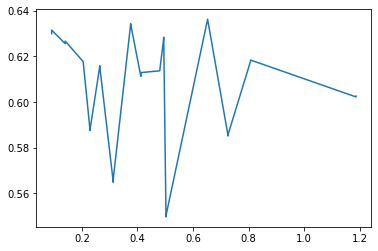

In [4]:
x = t1d_res["Labelled/Unlabelled Ratio"]
y = t1d_res['Average Accuracy Score']

zipped = zip(x, y)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x, y = [list(tuple) for tuple in tuples]

plt.plot(x, y, label='label/unlabel ratio')

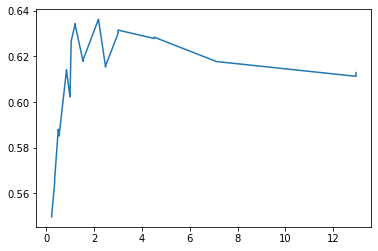

In [6]:
x = t1d_res["Pos/Neg ratio"]
y = t1d_res['Average Accuracy Score']

zipped = zip(x, y)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x, y = [list(tuple) for tuple in tuples]

plt.plot(x, y, label='label/unlabel ratio')

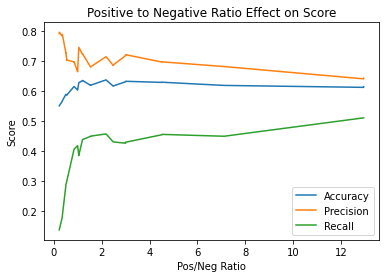

In [8]:
x = t1d_res["Pos/Neg ratio"]
x2 = t1d_res["Pos/Neg ratio"]
x3 = t1d_res["Pos/Neg ratio"]
y = t1d_res['Average Accuracy Score']
y2 = t1d_res['Average Precision Score']
y3 = t1d_res['Average Recall Score']

zipped = zip(x, y)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x, y = [list(tuple) for tuple in tuples]

zipped = zip(x2, y2)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x2, y2 = [list(tuple) for tuple in tuples]

zipped = zip(x3, y3)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x3, y3 = [list(tuple) for tuple in tuples]

plt.plot(x, y, label='Accuracy')
plt.plot(x2, y2, label='Precision')
plt.plot(x3, y3, label='Recall')
plt.title("Positive to Negative Ratio Effect on Score")
plt.xlabel("Pos/Neg Ratio")
plt.ylabel("Score")
plt.legend()

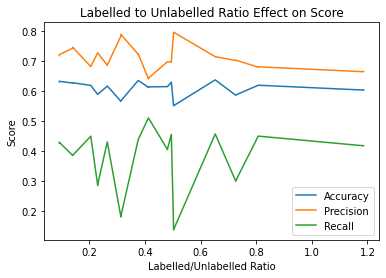

In [9]:
x = t1d_res["Labelled/Unlabelled Ratio"]
x2 = t1d_res["Labelled/Unlabelled Ratio"]
x3 = t1d_res["Labelled/Unlabelled Ratio"]
y = t1d_res['Average Accuracy Score']
y2 = t1d_res['Average Precision Score']
y3 = t1d_res['Average Recall Score']

zipped = zip(x, y)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x, y = [list(tuple) for tuple in tuples]

zipped = zip(x2, y2)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x2, y2 = [list(tuple) for tuple in tuples]

zipped = zip(x3, y3)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x3, y3 = [list(tuple) for tuple in tuples]

plt.plot(x, y, label='Accuracy')
plt.plot(x2, y2, label='Precision')
plt.plot(x3, y3, label='Recall')
plt.title("Labelled to Unlabelled Ratio Effect on Score")
plt.xlabel("Labelled/Unlabelled Ratio")
plt.ylabel("Score")
plt.legend()

In [11]:
t1d_res = pandas.read_csv("./Results/dedup_varid_no_norm.csv")

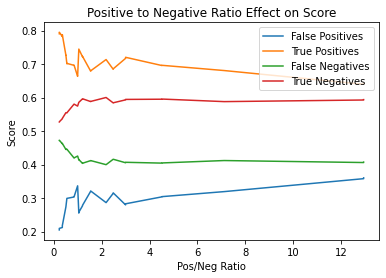

In [12]:
x = t1d_res["Pos/Neg ratio"]
x2 = t1d_res["Pos/Neg ratio"]
x3 = t1d_res["Pos/Neg ratio"]
x4 = t1d_res["Pos/Neg ratio"]
y = t1d_res['Avg False Positives']
y2 = t1d_res['Avg True Positives']
y3 = t1d_res['Avg False Negatives']
y4 = t1d_res['Average True Negatives']

zipped = zip(x, y)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x, y = [list(tuple) for tuple in tuples]

zipped = zip(x2, y2)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x2, y2 = [list(tuple) for tuple in tuples]

zipped = zip(x3, y3)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x3, y3 = [list(tuple) for tuple in tuples]

zipped = zip(x4, y4)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x4, y4 = [list(tuple) for tuple in tuples]

plt.plot(x, y, label='False Positives')
plt.plot(x2, y2, label='True Positives')
plt.plot(x3, y3, label='False Negatives')
plt.plot(x4, y4, label='True Negatives')
plt.title("Positive to Negative Ratio Effect on Score")
plt.xlabel("Pos/Neg Ratio")
plt.ylabel("Score")
plt.legend()

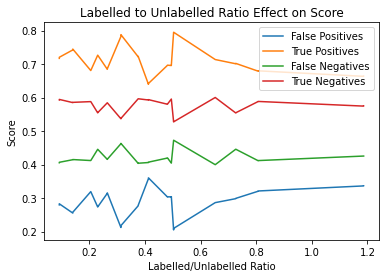

In [13]:
x = t1d_res["Labelled/Unlabelled Ratio"]
x2 = t1d_res["Labelled/Unlabelled Ratio"]
x3 = t1d_res["Labelled/Unlabelled Ratio"]
x4 = t1d_res["Labelled/Unlabelled Ratio"]
y = t1d_res['Avg False Positives']
y2 = t1d_res['Avg True Positives']
y3 = t1d_res['Avg False Negatives']
y4 = t1d_res['Average True Negatives']

zipped = zip(x, y)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x, y = [list(tuple) for tuple in tuples]

zipped = zip(x2, y2)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x2, y2 = [list(tuple) for tuple in tuples]

zipped = zip(x3, y3)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x3, y3 = [list(tuple) for tuple in tuples]

zipped = zip(x4, y4)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x4, y4 = [list(tuple) for tuple in tuples]

plt.plot(x, y, label='False Positives')
plt.plot(x2, y2, label='True Positives')
plt.plot(x3, y3, label='False Negatives')
plt.plot(x4, y4, label='True Negatives')
plt.title("Labelled to Unlabelled Ratio Effect on Score")
plt.xlabel("Labelled/Unlabelled Ratio")
plt.ylabel("Score")
plt.legend()

In [14]:
svc = pandas.read_csv('./Results/fixed_balanced_testing_SVC.csv')
res = pandas.read_csv('./Results/fixed_balanced_testing_rbf_results_no_norm.csv')
res_norm = pandas.read_csv('./Results/fixed_balanced_testing_rbf_results_minmax_norm.csv')
pca_20 = pandas.read_csv('./Results/fixed_balanced_testing_rbf_results_PCA_20_components_no_norm.csv')
pca_20_norm = pandas.read_csv('./Results/fixed_balanced_testing_rbf_results_PCA_20_components_normalized.csv')
bin_res = pandas.read_csv('./Results/fixed_balanced_testing_rbf_results_bin_data_no_norm.csv')
dedup_res = pandas.read_csv("./Results/dedup_varid_no_norm.csv")

In [15]:
print('Max accuracy')
print('svc:', max(svc['Average Accuracy Score']))
print('res:', max(res['Average Accuracy Score']))
print('res_norm:', max(res_norm['Average Accuracy Score']))
print('pca_20:', max(pca_20['Average Accuracy Score']))
print('pca_20_norm:', max(pca_20_norm['Average Accuracy Score']))
print('bin_res:', max(bin_res['Average Accuracy Score']))
print('dedup_res:', max(dedup_res['Average Accuracy Score']))

print('Max precision')
print('svc:', max(svc['Average Precision Score']))
print('res:', max(res['Average Precision Score']))
print('res_norm:', max(res_norm['Average Precision Score']))
print('pca_20:', max(pca_20['Average Precision Score']))
print('pca_20_norm:', max(pca_20_norm['Average Precision Score']))
print('bin_res:', max(bin_res['Average Precision Score']))
print('dedup_res:', max(dedup_res['Average Precision Score']))

print('Max recall')
print('svc:', max(svc['Average Recall Score']))
print('res:', max(res['Average Recall Score']))
print('res_norm:', max(res_norm['Average Recall Score']))
print('pca_20:', max(pca_20['Average Recall Score']))
print('pca_20_norm:', max(pca_20_norm['Average Recall Score']))
print('bin_res:', max(bin_res['Average Recall Score']))
print('dedup_res:', max(dedup_res['Average Recall Score']))

Max accuracy
svc: 0.6284090909090909
res: 0.6630681818181818
res_norm: 0.6661290322580646
pca_20: 0.65
pca_20_norm: 0.6363636363636364
bin_res: 0.6625
dedup_res: 0.6362637362637362
Max precision
svc: 0.85
res: 0.8205518018018019
res_norm: 0.7372173298452912
pca_20: 0.8771509086726479
pca_20_norm: 0.7621702858544964
bin_res: 0.762432615170952
dedup_res: 0.7949630642954856
Max recall
svc: 1.0
res: 0.5227272727272727
res_norm: 0.9806451612903226
pca_20: 0.5568181818181819
pca_20_norm: 0.9903225806451612
bin_res: 0.9838180856689582
dedup_res: 0.5096774193548387


In [10]:
len(t1d_data_raw[t1d_data_raw.duplicated(keep='first')])

4208